In [6]:
!pip install fredapi

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from fredapi import Fred
import creds

pd.set_option('display.max_columns',500)
plt.style.use('fivethirtyeight')
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# Create the FRED Object

In [8]:
fred = Fred(api_key = creds.fred_key)

# Search FRED

In [9]:
sp_search = fred.search('S&P', order_by = 'popularity')

In [10]:
sp_search.head(5)

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
BAMLH0A0HYM2,BAMLH0A0HYM2,2023-01-15,2023-01-15,ICE BofA US High Yield Index Option-Adjusted S...,1996-12-31,2023-01-12,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2023-01-13 08:32:14-06:00,94,The ICE BofA Option-Adjusted Spreads (OASs) ar...
CSUSHPINSA,CSUSHPINSA,2023-01-15,2023-01-15,S&P/Case-Shiller U.S. National Home Price Index,1987-01-01,2022-10-01,Monthly,M,Index Jan 2000=100,Index Jan 2000=100,Not Seasonally Adjusted,NSA,2022-12-27 08:02:01-06:00,90,"For more information regarding the index, plea..."
BAMLH0A0HYM2EY,BAMLH0A0HYM2EY,2023-01-15,2023-01-15,ICE BofA US High Yield Index Effective Yield,1996-12-31,2023-01-12,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2023-01-13 08:32:18-06:00,84,This data represents the effective yield of th...
SP500,SP500,2023-01-15,2023-01-15,S&P 500,2013-01-14,2023-01-13,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2023-01-13 19:11:03-06:00,84,The observations for the S&P 500 represent the...
CSUSHPISA,CSUSHPISA,2023-01-15,2023-01-15,S&P/Case-Shiller U.S. National Home Price Index,1987-01-01,2022-10-01,Monthly,M,Index Jan 2000=100,Index Jan 2000=100,Seasonally Adjusted,SA,2022-12-27 08:02:04-06:00,82,"For more information regarding the index, plea..."


# Pull Data and make some basic plots

In [11]:
sp500 = fred.get_series(series_id = 'SP500')

<AxesSubplot:title={'center':'S&P 500'}>

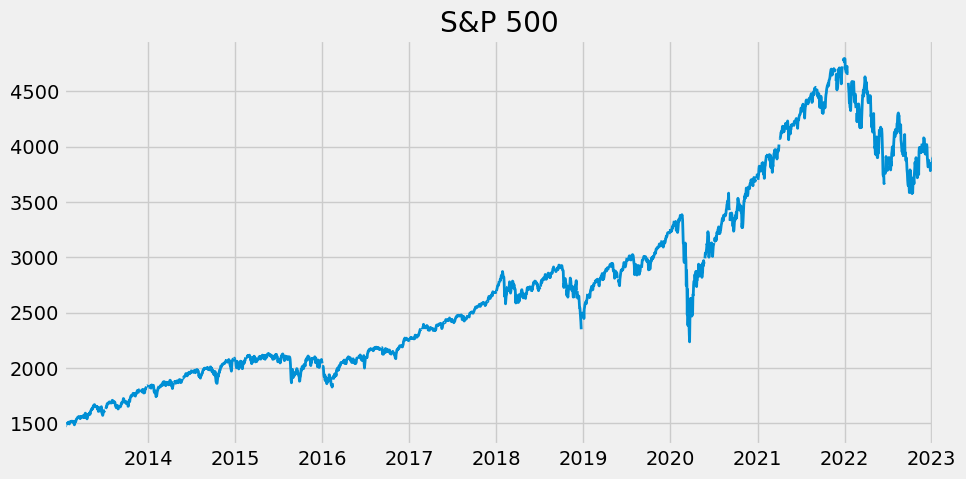

In [12]:
sp500.plot(figsize = (10,5), title = 'S&P 500', lw = 2)